# Mount google drive into google colab


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Let's unzip the dataset.

In [ ]:
from zipfile import ZipFile

with ZipFile("/content/gdrive/My Drive/Covid X-ray dataset.zip", 'r') as file:
    file.extractall(path='/content/')

# Import Dependencies

In [ ]:
import os
import tensorflow as tf
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# We are going to use ImageDataGenerator 
(check https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). 





In [ ]:
train_dir_path = "/content/dataset/train" # path to train folder
val_dir_path = "/content/dataset/validation"   # path to validation folder


train_data_generator = ImageDataGenerator(rescale=1/255, rotation_range=90, 
                                          horizontal_flip=True, vertical_flip=True)
# define val_data_generator
val_data_generator = ImageDataGenerator(rescale=1/255) 


batch_size = 64 # set it properly
class_names = os.listdir(train_dir_path) 


train_gen = train_data_generator.flow_from_directory(train_dir_path, batch_size=batch_size, 
                                                     classes=class_names)

val_gen = val_data_generator.flow_from_directory(val_dir_path, batch_size=batch_size, 
                                                 classes=class_names)

Found 7367 images belonging to 3 classes.
Found 1841 images belonging to 3 classes.


# Plot some examples from train_dataset

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


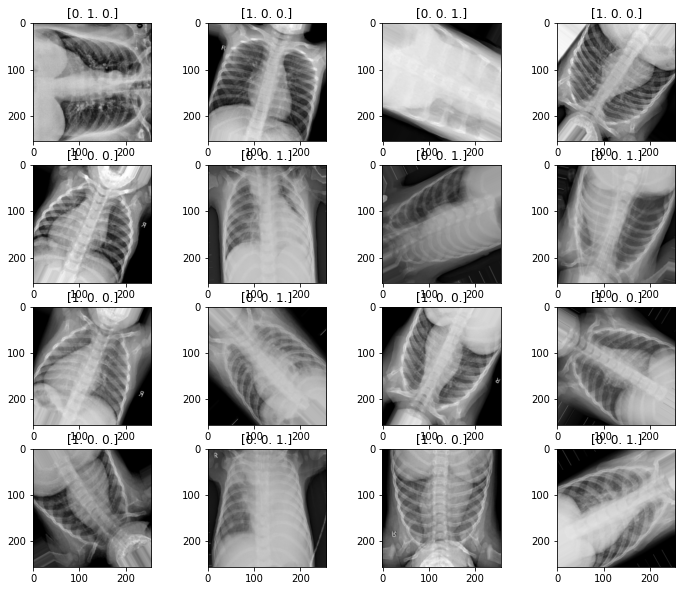

In [ ]:
first_batch = next(train_gen)

# plot 16 images
plt.figure(figsize=(12, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(first_batch[0][i])
    plt.title(first_batch[1][i])
plt.show()

# Get a pretrained model (say ResNet50)

In [ ]:
feature_extractor = ResNet50(include_top=False,
                             weights='imagenet',
                             input_shape=(256, 256, 3),
                             pooling='avg') 

feature_extractor_output = feature_extractor.layers[-1].output

fc = tf.keras.layers.Dense(3, activation='softmax')(feature_extractor_output) 
                               
# define the model:
model = Model(feature_extractor.input, fc)

# freeze some layers
# for layer in model.layers[:-7]:
#     layer.trainable=False


# Compile and fit the model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_path = "/content/resnet50.ckpt"

save_ckpt = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                   save_weights_only=True,
                                   save_best_only=True,
                                   monitor='val_loss',
                                   frequency='epoch')

history = model.fit(train_gen, epochs=10, verbose=1, 
                    steps_per_epoch=len(train_gen),
                    validation_data=val_gen, 
                    validation_steps=len(val_gen),
                    callbacks=[save_cktp])

Epoch 1/10
116/116 [==============================] - 153s 1s/step - loss: 0.2044 - accuracy: 0.9317 - val_loss: 2.1703 - val_accuracy: 0.5057
Epoch 2/10
116/116 [==============================] - 144s 1s/step - loss: 0.1124 - accuracy: 0.9600 - val_loss: 3.1891 - val_accuracy: 0.1391
Epoch 3/10
116/116 [==============================] - 144s 1s/step - loss: 0.1011 - accuracy: 0.9623 - val_loss: 2.8602 - val_accuracy: 0.1037
Epoch 4/10
116/116 [==============================] - 147s 1s/step - loss: 0.1155 - accuracy: 0.9620 - val_loss: 5.6488 - val_accuracy: 0.1391
Epoch 5/10
116/116 [==============================] - 145s 1s/step - loss: 0.0804 - accuracy: 0.9733 - val_loss: 4.1310 - val_accuracy: 0.1608
Epoch 6/10
116/116 [==============================] - 144s 1s/step - loss: 0.0685 - accuracy: 0.9764 - val_loss: 5.5525 - val_accuracy: 0.5242
Epoch 7/10
116/116 [==============================] - 153s 1s/step - loss: 0.0652 - accuracy: 0.9769 - val_loss: 4.8544 - val_accuracy: 0.5231

# Plot loss & accuracy curves

In [ ]:
predictions = model.predict(val_gen)

29/29 [==============================] - 8s 262ms/step


In [ ]:
predictions = predictions.argmax(axis=1)

In [ ]:
val_labels = []
for i, batch in enumerate(val_gen):
    if i >= len(val_gen):
        break
    labels = []
    for j, row in enumerate(batch[1]):
        labels.append(np.where(row==1)[0][0])
    val_labels += labels

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(val_labels), predictions))

              precision    recall  f1-score   support

           0       0.35      0.36      0.36       658
           1       0.13      0.17      0.15       243
           2       0.50      0.44      0.47       940

    accuracy                           0.38      1841
   macro avg       0.33      0.33      0.32      1841
weighted avg       0.40      0.38      0.39      1841

